In [2]:
from astropy.io import fits
from astropy.stats import sigma_clip
import numpy as np
from scipy import ndimage

In [5]:
a = np.arange(12).reshape((3,4))
a

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [7]:
np.indices(a.shape)


array([[[0, 0, 0, 0],
        [1, 1, 1, 1],
        [2, 2, 2, 2]],

       [[0, 1, 2, 3],
        [0, 1, 2, 3],
        [0, 1, 2, 3]]])

In [26]:
labels = np.zeros_like(a)
labels[:2,:2] = 4
labels[2:, 1:3] = 3
labels

array([[4, 4, 0, 0],
       [4, 4, 0, 0],
       [0, 3, 3, 0],
       [0, 3, 3, 0]])

In [31]:
ndimage.maximum(a, labels, index=list({3,4}))

array([14,  5])

In [22]:
a=set(range(2,10))
a

{2, 3, 4, 5, 6, 7, 8, 9}

In [23]:
a.remove(2)
a

{3, 4, 5, 6, 7, 8, 9}

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [3]:
fits_path = '../casapy-simulation-scripts/simulation_output/vla.image.fits'

Load the data. A mask can be applied if necessary - this may be useful e.g. for excluding the region around a bright source, to avoid false detections due to sidelobes.

In [4]:
hdu0 = fits.open(fits_path)[0]
imgdata = hdu0.data.squeeze()
# imgdata = np.ma.MaskedArray(imgdata, mask=np.zeros_like(imgdata))
# imgdata.mask[900:1100,900:1100] = True
# imgdata.mask.any()

In [5]:
# Plot pixels in cartesian ordering:
plt.rcParams['image.origin'] = 'lower'
# Make plots bigger
plt.rcParams['figure.figsize'] = 10, 10

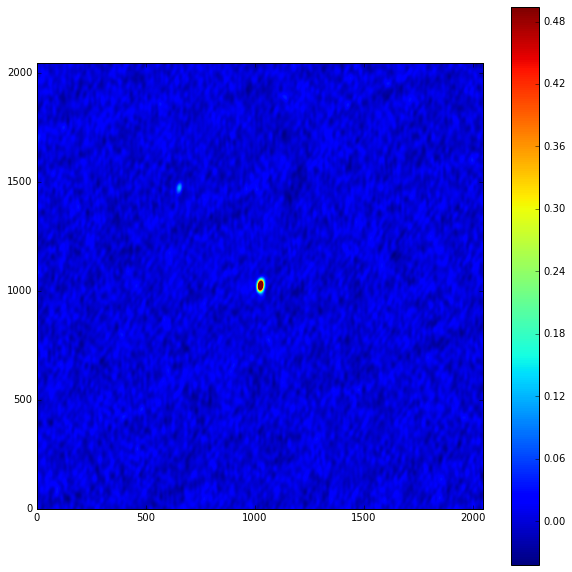

In [6]:
imgmax = np.max(imgdata)
plt.imshow(imgdata,vmax=imgmax*0.5)
plt.colorbar()

Crudely estimate the background level and RMS:

In [7]:
clipped = sigma_clip(imgdata)
rms = np.ma.std(clipped)
bg_estimate = np.ma.median(imgdata)

We use two thresholds when identifying our source 'islands' (connected pixel regions). The high threshold is our detection level, and should be set high enough to avoid false detections due to noise spikes. The lower threshold expands each island, such that it is more likely to contain enough pixels to reasonably fit a Gaussian profile (otherwise the island may consist of only a single pixel over the detection threshold).

Note that this thresholding approach may result in multi-peaked regions (e.g. two distinct but adjacent sources) being assigned to a single island / label. This can be tackled with 'deblending' algorithms if desired, but is not covered in this notebook.

In [8]:
analysis_threshold = bg_estimate + 3*rms
detection_threshold = bg_estimate + 6*rms

In [9]:
analysis_pix = imgdata > analysis_threshold
high_pix = imgdata > detection_threshold

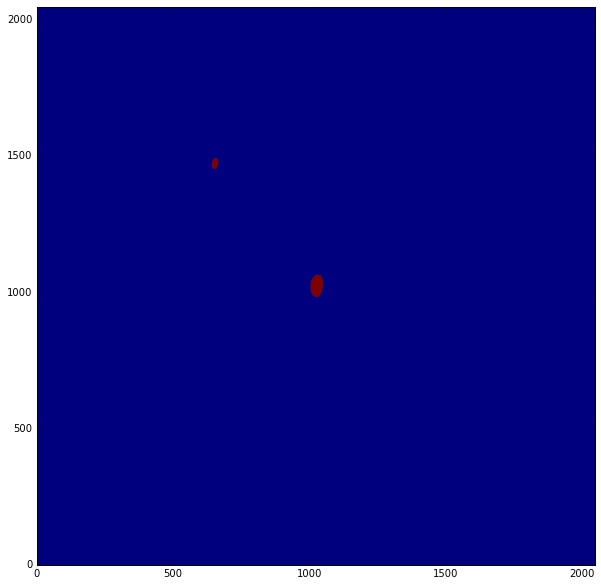

In [10]:
plt.imshow(high_pix)

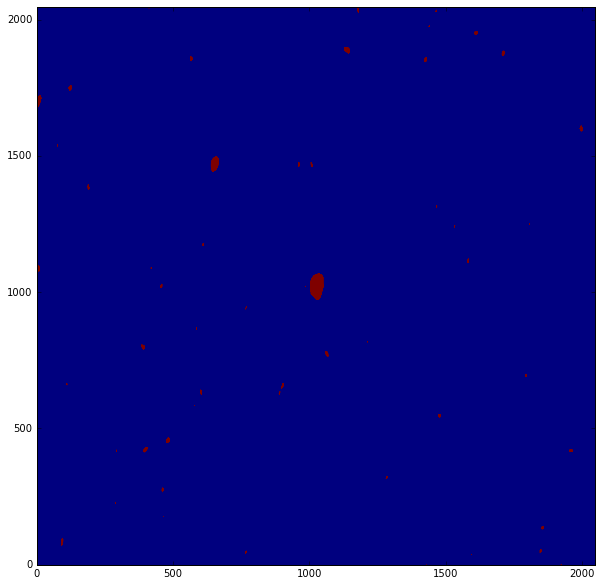

In [11]:
plt.imshow(analysis_pix)

In [12]:
labeldata, n_labels = ndimage.label(analysis_pix)

Copy the mask from the input dataset, if it has one (ndimage.label doesn't account for masks):

In [13]:
labeldata = np.ma.MaskedArray(labeldata, mask=np.ma.getmask(imgdata))

Check the label of our bright central source:

In [14]:
labeldata[1010,1010]

29

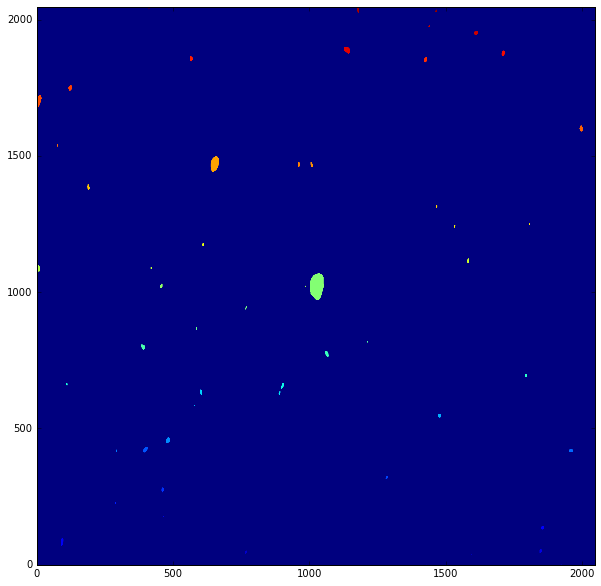

In [15]:
plt.imshow(labeldata)

In [16]:
def get_label_mask(labeldata, label_num):
    return ~(labeldata==label_num)

In [17]:
def get_island_data(imgdata,labeldata,label_num):
    return np.ma.MaskedArray(imgdata, mask=( get_label_mask(labeldata, label_num) ))

In [18]:
central_source_island = get_island_data(imgdata,labeldata, label_num=29)
# unmasked_island = get_island_data(imgdata.data,labeldata, label_num=29)

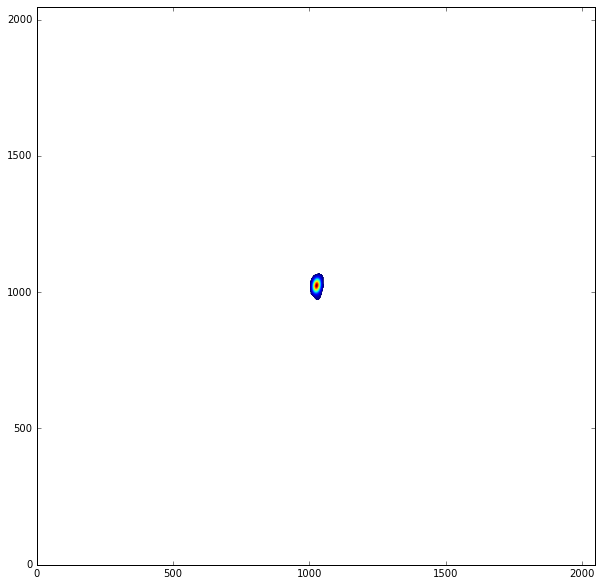

In [19]:
plt.imshow(central_source_island)

Now we loop over all 'analysis threshold' level islands and see which ones peak above the detection level.

In [20]:
clear_detection_labels = []
for i in range(n_labels):
    if (get_island_data(imgdata,labeldata,label_num=i)>detection_threshold).any():
        clear_detection_labels.append(i)

In [21]:
clear_detection_labels

[29, 42]

As a final check, let's plot the islands which appear to be 'clear detections':

In [22]:
# Mask all pixels to start with:
combined_mask = np.ones_like(imgdata)
for i in clear_detection_labels:
    # Combine with each island mask to open a hole for each source.
    combined_mask = np.logical_and(combined_mask, get_label_mask(labeldata,i))
all_clear_detections_data = np.ma.MaskedArray(imgdata, mask=combined_mask)

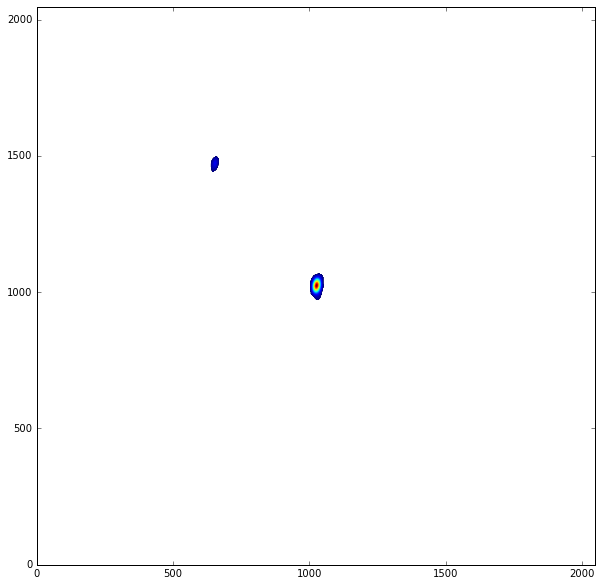

In [23]:
plt.imshow(all_clear_detections_data)

Get the peak pixel for each island. The function ``np.ma.argmax`` returns the index of the peak pixel in the flattened data, so we massage it back into (y,x) index form:

In [24]:
def get_peak_pixel_index(island_data):
    return np.unravel_index(np.ma.argmax(island), imgdata.shape)

In [25]:
island_num = clear_detection_labels[-1]
island = get_island_data(imgdata, labeldata, island_num)
peak_pixel_index = get_peak_pixel_index(island)
peak_pixel_index

(1471, 652)

In [26]:
peak_pixel_value = island[peak_pixel_index]
peak_pixel_value 

0.12205875

(1421, 1521)

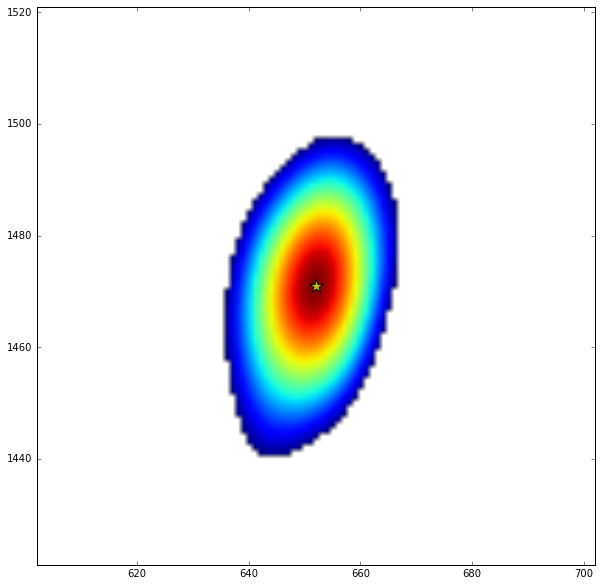

In [27]:
plt.imshow(island)
y, x = peak_pixel_index
plt.scatter(x,y, marker='*', s=200, c='y',)
plt.xlim(x-50,x+50)
plt.ylim(y-50,y+50)